### Read in overlaid data

In [1]:
import pandas as pd
df = pd.read_parquet('./material/soil_organized.pq')
print(df.shape)

(409369, 644)


### Keep valid soc measurements

In [2]:
df = df.loc[df['soc_qa']>2]
print(df.shape)
df = df.dropna(subset=['soc'],how='any')
print(df.shape)

(124625, 644)
(121394, 644)


### Harmonize soc measurements to be topsoil

In [3]:
import numpy as np
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from skmap.misc import TimeTracker, ttprint

single_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) == 1)
single_records = single_depth_groups[single_depth_groups['hzn_dep'] <= 20].copy()
single_records['type'] = 'measured'
print("keep single-depth records with hzn_dep <= 20 cm, ", single_records.shape)

keep single-depth records with hzn_dep <= 20 cm,  (93498, 645)


In [4]:
multi_depth_groups = df.groupby(['lat', 'lon', 'time']).filter(lambda g: len(g) > 1)
multi_with_10 = multi_depth_groups[multi_depth_groups['hzn_dep'] == 10]
multi_records_10 = multi_with_10.copy()  
multi_records_10['type'] = 'measured'
print("Keep multi-depth records where hzn_dep = 10:", multi_records_10.shape)

Keep multi-depth records where hzn_dep = 10: (1667, 645)


In [5]:
multi_depth_interpolate = multi_depth_groups.groupby(['lat', 'lon', 'time']).filter(lambda g: not (g['hzn_dep'] == 10).any())
print("multi-depth group needs interpolation count:", multi_depth_interpolate.shape)

itpl_records = []
for (lat, lon, time), group in multi_depth_interpolate.groupby(['lat', 'lon', 'time']):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])
    new_record = group.iloc[0].copy()  # keep all other columns
    for prop in ['soc','total.n','clay','ph.h2o','ph.cacl2']:
        try:
            # cs = CubicSpline(group['hzn_dep'], group[prop])
            pc = PchipInterpolator(group['hzn_dep'], group[prop])
            new_record[prop] = pc(10).item()  # interpolte
        except Exception as e:
            new_record[prop] = np.nan
            # print(f"Interpolation error at ({group['lat'].iloc[0]}, {group['lon'].iloc[0]}, {group['time'].iloc[0]}): {e}")
    new_record['hzn_dep'] = 10  # same as standard LUCAS depth
    itpl_records.append(new_record)
    
interpolated_records = pd.DataFrame(itpl_records)
interpolated_records['type'] = 'interpolated'
print("Interpolating hzn_dep==10cm for multi-depth groups,", interpolated_records.shape)

multi-depth group needs interpolation count: (24867, 644)
Interpolating hzn_dep==10cm for multi-depth groups, (5985, 645)


In [6]:
dff = pd.concat([single_records, multi_records_10, interpolated_records], ignore_index=True)
print("topsoil harmonized, ", dff.shape)


topsoil harmonized,  (101150, 645)


### Visualize some examples

In [7]:
num_examples = 3
selected_groups = interpolated_records.sample(n=num_examples, random_state=42)[['lat', 'lon', 'time']]  # Select 3 unique groups
selected_examples = multi_depth_groups.merge(selected_groups, on=['lat', 'lon', 'time'])

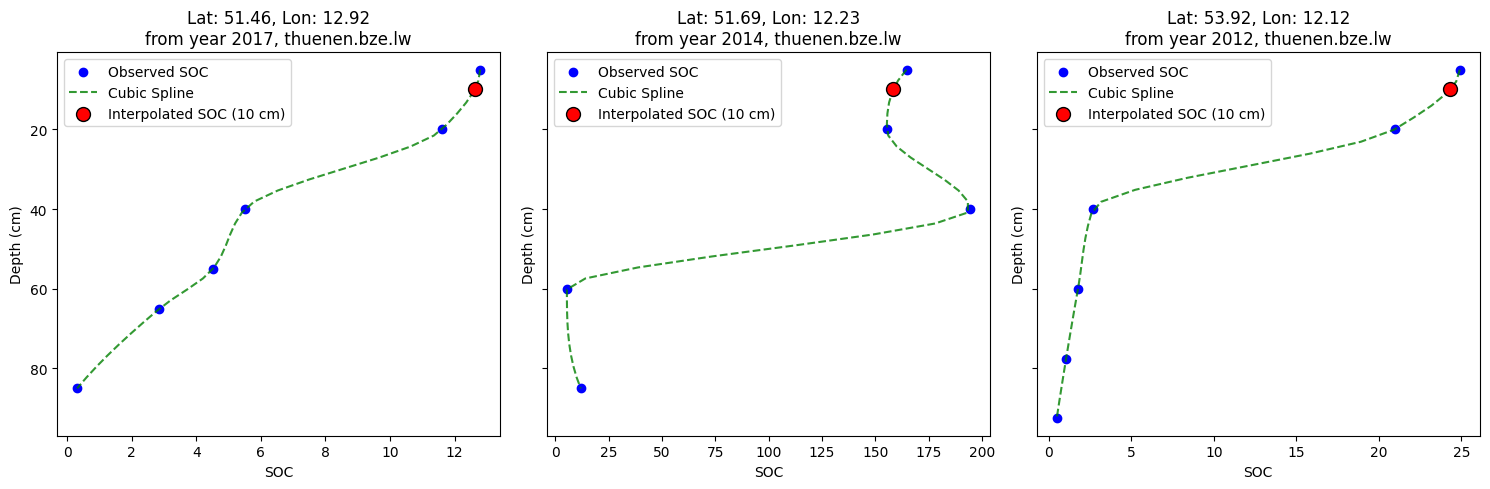

In [8]:
import matplotlib.pyplot as plt
import random
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5), sharey=True)

for ax, ((lat, lon, time, ref), group) in zip(axes, selected_examples.groupby(['lat', 'lon','time','ref'])):
    group = group.sort_values(by='hzn_dep').drop_duplicates(subset=['hzn_dep'])

    pc = PchipInterpolator(group['hzn_dep'], group['soc'])
    depths = np.linspace(min(group['hzn_dep']), max(group['hzn_dep']), 30)
    soc_spline = pc(depths)
    interpolated_soc = pc(10)  

    ax.scatter(group['soc'], group['hzn_dep'], label="Observed SOC", color='blue', zorder=2)
    
    ax.plot(soc_spline, depths, label="Cubic Spline", linestyle='--', color='green', alpha=0.8)

    ax.scatter(interpolated_soc, 10, color='red', s=100, edgecolor='black', label="Interpolated SOC (10 cm)", zorder=3)

    ax.invert_yaxis()  # Depth increases downwards
    ax.set_ylabel("Depth (cm)")  
    ax.set_xlabel("SOC")  
    ax.set_title(f"Lat: {round(lat,2)}, Lon: {round(lon,2)}\nfrom year {time}, {ref}")
    ax.legend()

plt.tight_layout()
plt.show()


### Clean out some columns

In [10]:
drop_col = ['soc_qa', 'bulk.density.tot_qa', 'bulk.density.tot',
       'bulk.density.fe_qa', 'bulk.density.fe', 'coarse.mass_qa',
       'coarse.mass', 'coarse.vol_qa', 'coarse.vol', 'ocd', 'ph.h2o_qa',
       'sand_qa', 'sand', 'silt_qa', 'silt', 'clay_qa', 
       'total.n_qa', 'carbonates_qa', 'carbonates', 'ph.cacl2_qa',
        'extractable.p_qa', 'extractable.p', 'extractable.k_qa',
       'extractable.k', 'ec_qa', 'ec', 'cec_qa', 'cec','texture1', 'texture2', 
            'texture1_qa', 'texture2_qa']

dff = dff.drop(columns=drop_col)
print(dff.shape)

(101150, 613)


In [12]:
dff.to_parquet('./material/soc.topsoil_organized.pq')